In [1]:
# Don't do this. Do as I say and not as I code.
import sys
sys.path.insert(0, "../") 

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy import (coordinates as coord, units as u)
from astroquery.simbad import Simbad
from astropy.io import fits
from astropy.table import Table

from mpl_utils import mpl_style

plt.style.use(mpl_style)

%matplotlib inline

In [2]:
GALAH_CATALOG_PATH = "../catalogs/GALAH_DR2.1_catalog.fits"
#galah = fits.open(GALAH_CATALOG_PATH)[1].data
galah = Table.read(GALAH_CATALOG_PATH)


In [3]:
galah

star_id,sobject_id,gaia_dr2_id,ndfclass,field_id,raj2000,dej2000,jmag,hmag,kmag,vmag_jk,e_jmag,e_hmag,e_kmag,snr_c1,snr_c2,snr_c3,snr_c4,rv_synt,e_rv_synt,rv_obst,e_rv_obst,rv_nogr_obst,e_rv_nogr_obst,chi2_cannon,sp_label_distance,flag_cannon,teff,e_teff,logg,e_logg,fe_h,e_fe_h,vmic,e_vmic,vsini,e_vsini,alpha_fe,e_alpha_fe,li_fe,e_li_fe,flag_li_fe,c_fe,e_c_fe,flag_c_fe,o_fe,e_o_fe,flag_o_fe,na_fe,e_na_fe,flag_na_fe,mg_fe,e_mg_fe,flag_mg_fe,al_fe,e_al_fe,flag_al_fe,si_fe,e_si_fe,flag_si_fe,k_fe,e_k_fe,flag_k_fe,ca_fe,e_ca_fe,flag_ca_fe,sc_fe,e_sc_fe,flag_sc_fe,ti_fe,e_ti_fe,flag_ti_fe,v_fe,e_v_fe,flag_v_fe,cr_fe,e_cr_fe,flag_cr_fe,mn_fe,e_mn_fe,flag_mn_fe,co_fe,e_co_fe,flag_co_fe,ni_fe,e_ni_fe,flag_ni_fe,cu_fe,e_cu_fe,flag_cu_fe,zn_fe,e_zn_fe,flag_zn_fe,y_fe,e_y_fe,flag_y_fe,ba_fe,e_ba_fe,flag_ba_fe,la_fe,e_la_fe,flag_la_fe,eu_fe,e_eu_fe,flag_eu_fe
,,,,,deg,deg,mag,mag,mag,mag,mag,mag,mag,,,,,km / s,km / s,km / s,km / s,km / s,km / s,,,,K,K,log(cm/s**2),log(cm/s**2),,,km / s,km / s,km / s,km / s,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
str16,int64,int64,str12,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64
00000011+0522500,170910004101274,2745049530295263232,MFOBJECT,6882,0.00047,5.380571,11.247,10.662,10.539,13.29013142182967,0.023,0.021,0.019,21.6842438247,25.642019541,48.2577818878,56.7736953398,11.2785006196,0.10554313024226696,nan,nan,nan,nan,0.9686406055148505,26.117479302928928,1,4576.3146556900165,73.66606152161543,4.69921301415962,0.20325334996983807,-0.34715658604637595,0.0858256649316195,1.0402612320260698,0.04780623250819824,5.842923719979717,1.137324347810317,nan,nan,0.08814637856703222,0.036974729677661515,9,0.1767276669285896,0.12066299569491594,7,0.917111108763486,0.12488473782575324,7,-0.02697108553652898,0.05739079406012904,3,-0.27784443564094446,0.09104559780809049,3,0.1192836438175516,0.05014576539801681,3,-0.5213135214004853,0.08367885808642318,4,-0.07828451329189948,0.1105459049204072,3,0.2636871283785336,0.06430052174371603,3,0.24947225252755315,0.05430142402788317,3,0.1993616391387553,0.04245711713403249,3,0.5272384234558806,0.06819817858156826,3,-0.017008873233296695,0.06848921533230523,3,-0.28099685115686907,0.07106827513025585,3,-0.032079478105687516,0.05902655519022573,3,0.09768408598746328,0.07118604779902064,3,0.03449119709150463,0.0675336516468829,3,-0.316891222233664,0.08378329657164789,4,0.2800804604999586,0.09618677820229367,3,0.0020769516248465847,0.11050615030944015,3,0.1513767947925168,0.06994674998573366,7,0.06383755210346904,0.14885420501563815,7
00000023-5709445,161116001701360,4922452332795612416,MFOBJECT,6863,0.000961,-57.162365,12.219,11.707,11.614,13.962700850910407,0.023,0.025,0.023,35.4352269965,44.8624165399,77.100807268,61.57035197,-17.0524752475,0.22204866610544016,nan,nan,nan,nan,1.1302555774403251,9.481671746009932,1,5168.714783718918,69.26343220626434,4.417376173707199,0.18537860563660696,-0.8399120515061285,0.07626677163678232,1.052628515431911,0.043236608109176955,8.310857910725424,1.0437913042541966,nan,nan,1.2327808340880901,0.034874843628975874,9,0.17228231706904168,0.09017881957321548,7,0.5019640877763372,0.11119965231157877,7,-0.024790781231829796,0.0519223318192827,3,0.277602119753392,0.08199969469069114,3,0.2546160563668588,0.04535553578385894

In [6]:
element_label_names = [ln for ln in galah.dtype.names if ln.endswith("_fe") and not ln.startswith(("flag_", "e_", "alpha_"))]
print("\n".join(element_label_names))

li_fe
c_fe
o_fe
na_fe
mg_fe
al_fe
si_fe
k_fe
ca_fe
sc_fe
ti_fe
v_fe
cr_fe
mn_fe
co_fe
ni_fe
cu_fe
zn_fe
y_fe
ba_fe
la_fe
eu_fe


In [7]:
# Select a subset of stars and abundances
is_ok = dict()
for label_name in element_label_names:
    is_ok[label_name] = sum(galah["flag_{}".format(label_name)] == 0)

In [8]:
import operator
for k, v in sorted(is_ok.items(), key=operator.itemgetter(1))[::-1]:
    print(k, v)

na_fe 265806
mg_fe 264551
sc_fe 251749
ti_fe 250655
zn_fe 248993
mn_fe 247222
y_fe 244475
ca_fe 240420
ni_fe 235944
cr_fe 235783
o_fe 230613
si_fe 228337
k_fe 214247
ba_fe 206675
v_fe 184428
cu_fe 184380
al_fe 178739
la_fe 52715
eu_fe 42901
c_fe 29126
co_fe 18332
li_fe 3963


In [15]:
use_element_label_names = [k for k, v in sorted(is_ok.items(), key=operator.itemgetter(1))[::-1]][:14]

meets_qc = (galah["flag_cannon"] == 0)
print(sum(meets_qc))
for label_name in use_element_label_names:
    meets_qc *= (galah["flag_{}".format(label_name)] == 0) \
              * (np.isfinite(galah[label_name]))
    print(label_name, sum(meets_qc))

use_element_label_names.append("fe_h")
    
N = sum(meets_qc)
D = len(use_element_label_names)
print("N = {0}, D = {1}".format(N, D))  

264227
na_fe 239580
mg_fe 226436
sc_fe 209213
ti_fe 195146
zn_fe 179550
mn_fe 169286
y_fe 155500
ca_fe 146109
ni_fe 134787
cr_fe 125124
o_fe 111499
si_fe 101675
k_fe 86929
ba_fe 77881
N = 77881, D = 15


In [18]:
# I'll take it.

In [36]:
import stan_utils as stan

subsample = 10000 # subsample the data for testing

# TODO: Order the abundances to minimise the impact of the zero-ed out factor loads.
y = np.array([galah[ln][meets_qc] for ln in use_element_label_names]).T

if subsample is not None:
    print("Sub-sampling only {} stars".format(subsample))
    idx = np.random.choice(y.shape[0], subsample, replace=False)
    y = y[idx]
    

fe_h_index = list(use_element_label_names).index("fe_h")
for d in range(D):
    if d == fe_h_index: continue
    y[:, d] += y[:, fe_h_index]
    
N, D = y.shape

mean = np.mean(y, axis=0)
assert mean.size == D
y = y - mean

assert N > D
assert np.all(np.isfinite(y))
assert np.allclose(np.mean(y, axis=0), np.zeros(D))

J = 3

data = dict(y=y, N=N, D=D, J=J)


Sub-sampling only 10000 stars


In [120]:
# Plot the data.
from scipy.stats import binned_statistic_2d
from matplotlib.colors import LogNorm

def corner_hist(x, bins=30, label_names=None, show_ticks=False, **kwargs):
    N, D = x.shape
    A = D - 1
    fig, axes = plt.subplots(A, A, figsize=(2 * A, 2 * A))

    kwds = dict(cmap="Greys", norm=LogNorm())
    kwds.update(kwargs)
    
    for i, ax_row in enumerate(axes):
        for j, ax in enumerate(ax_row):
            if j >= i:
                ax.set_visible(False)
                continue

            H, xedges, yedges, binnumber = binned_statistic_2d(
                x.T[i], x.T[j], x.T[i], statistic="count", bins=bins)

            imshow_kwds = dict(
                aspect=np.ptp(xedges)/np.ptp(yedges), 
                extent=(xedges[0], xedges[-1], yedges[-1], yedges[0]))
            imshow_kwds.update(kwds)
            
            image = ax.imshow(H.T, **imshow_kwds)
            ax.set_ylim(ax.get_ylim()[::-1])
        

            if ax.is_last_row() and label_names is not None:
                ax.set_xlabel(label_names[j])
                
            if ax.is_first_col() and label_names is not None:
                ax.set_ylabel(label_names[i])
                
            if not show_ticks:
                ax.set_xticks([])
                ax.set_yticks([])
                
    fig.tight_layout()
    
    return fig


def corner_scatter(data, label_names=None, show_ticks=False, fig=None,
                   **kwargs):
    N, D = data.shape
    K = D 
    
    if fig is None:
        fig, axes = plt.subplots(K, K, figsize=(2 * K, 2 * K))
        
    else:
        axes = fig.axes
    
    kwds = dict(s=1, c="tab:blue", alpha=0.5)
    kwds.update(kwargs)
    
    axes = np.atleast_2d(axes).T
    
    for j, y in enumerate(data.T):
        for i, x in enumerate(data.T):
            
            try:
                ax = axes[K - i - 1, K - j - 1]
            
            except:
                continue
            
            if j >= i: 
                ax.set_visible(False)
                continue
            
            ax.scatter(x, y, **kwds)
            
            if not show_ticks:
                ax.set_xticks([])
                ax.set_yticks([])

            if ax.is_last_row() and label_names is not None:
                ax.set_xlabel(label_names[i])
                
            if ax.is_first_col() and label_names is not None:
                ax.set_ylabel(label_names[j])
                
    fig.tight_layout()
    
    return fig


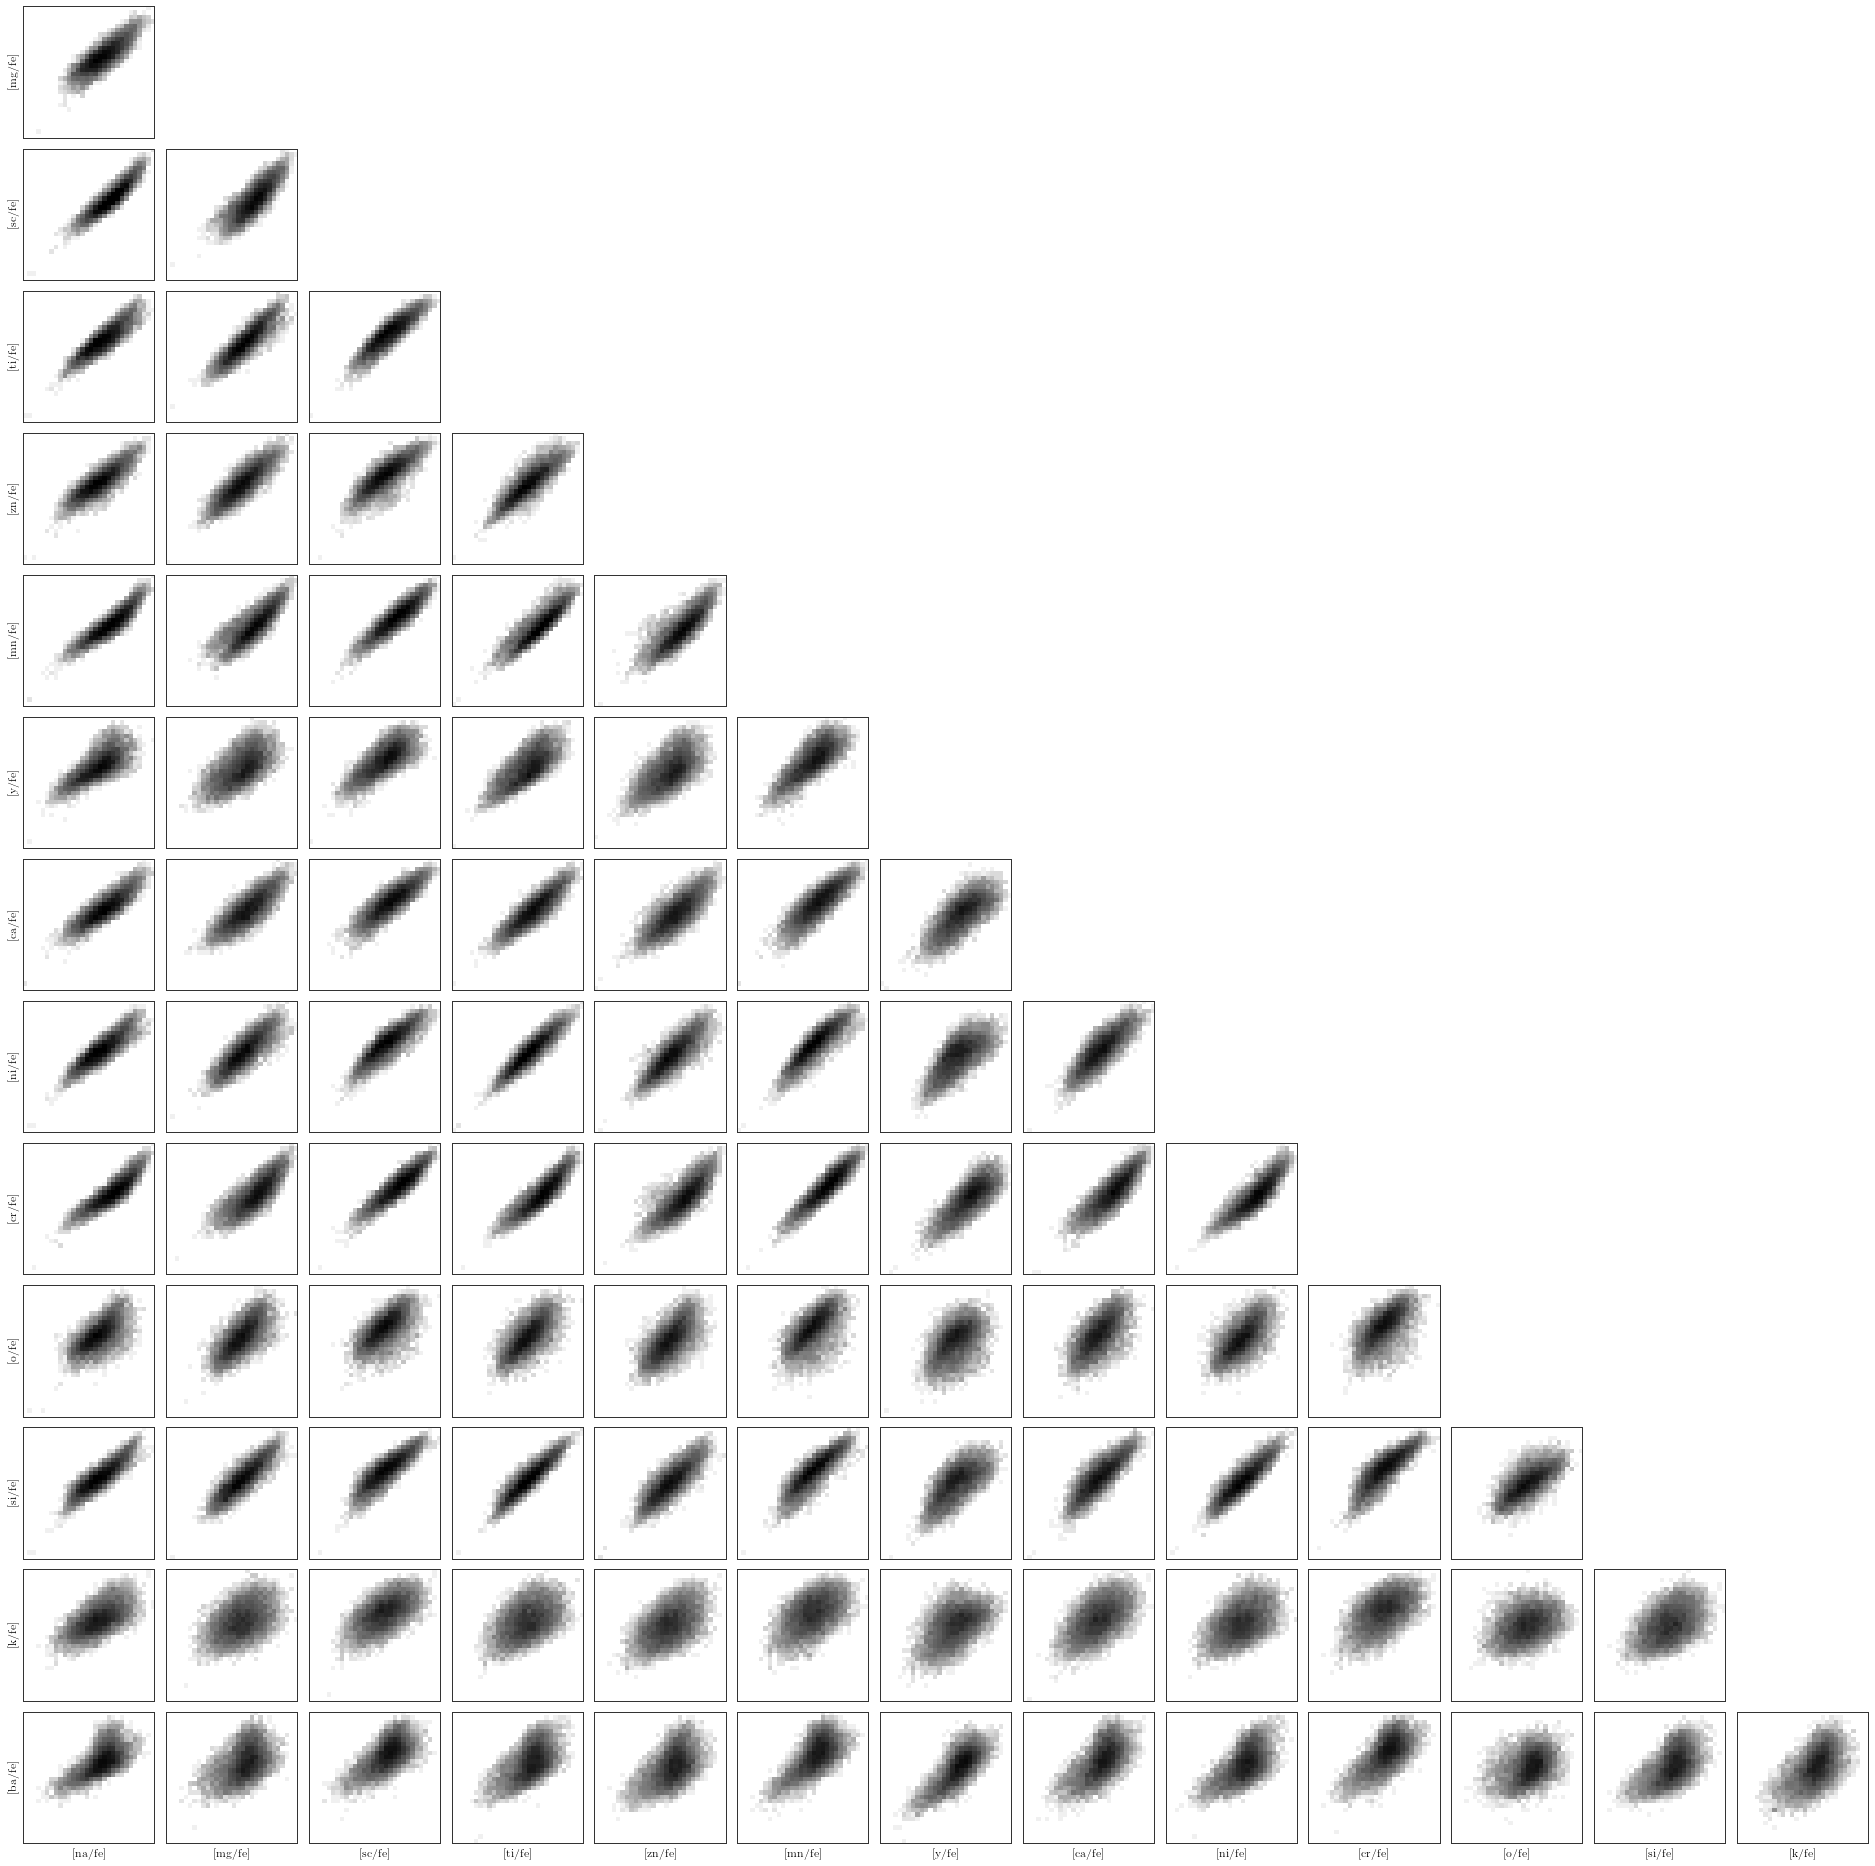

In [38]:
latex_label_name = lambda ln: r"\textrm{{[{0}]}}".format(ln.replace("_", "/"))
fig = corner_hist(y, 
                  label_names=[latex_label_name(ln) for ln in use_element_label_names],
                  show_ticks=False)
#fig = corner_scatter(y)

In [39]:
np.mean(data["y"], axis=0)

array([ 3.48554519e-17,  1.38278278e-17,  5.28466160e-18,  2.06934470e-16,
        5.39007727e-16,  2.51765275e-16, -5.97299987e-18, -8.53039861e-17,
        1.15130128e-17,  8.14182055e-17,  6.35880237e-17, -3.37507799e-18,
       -6.15341111e-17, -2.51298982e-17,  1.59205982e-17])

In [40]:
default_op_kwds = dict(
    init_alpha=0.001,
    tol_obj=1e-12,
    tol_grad=1e-8,
    tol_param=1e-8,
    tol_rel_grad=1e7
)

op_kwds = default_op_kwds.copy()
op_kwds.update(
    iter=10000,
    data=data,
    tol_obj=1e-16,
    tol_grad=1e-16,
    tol_param=1e-16,
    tol_rel_grad=1e-16,
    init_alpha=1.0,
)


model = stan.load_stan_model("../mlf.stan")
opt = model.optimizing(**op_kwds)

INFO:root:Using pre-compiled model from ../mlf.stan.cached
/home/acas0005/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [ ]:
# Should we initialize the latent factors at the principal components?

In [41]:
periodic_table = """H                                                  He
                    Li Be                               B  C  N  O  F  Ne
                    Na Mg                               Al Si P  S  Cl Ar
                    K  Ca Sc Ti V  Cr Mn Fe Co Ni Cu Zn Ga Ge As Se Br Kr
                    Rb Sr Y  Zr Nb Mo Tc Ru Rh Pd Ag Cd In Sn Sb Te I  Xe
                    Cs Ba Lu Hf Ta W  Re Os Ir Pt Au Hg Tl Pb Bi Po At Rn
                    Fr Ra Lr Rf"""

lanthanoids    =   "La Ce Pr Nd Pm Sm Eu Gd Tb Dy Ho Er Tm Yb"
actinoids      =   "Ac Th Pa U  Np Pu Am Cm Bk Cf Es Fm Md No"

periodic_table = periodic_table.replace(" Ba ", " Ba " + lanthanoids + " ") \
                               .replace(" Ra ", " Ra " + actinoids + " ") \
                               .split()
    
# Create an array of Z values for plotting, etc
Z = 1 + np.array([periodic_table.index(ln.split("_")[0].title()) for ln in use_element_label_names])
zi = np.argsort(Z)
ordered_element_label_names = [use_element_label_names[i].split("_")[0].title() for i in zi]

[Text(0,0,'O'),
 Text(0,0,'Na'),
 Text(0,0,'Mg'),
 Text(0,0,'Si'),
 Text(0,0,'K'),
 Text(0,0,'Ca'),
 Text(0,0,'Sc'),
 Text(0,0,'Ti'),
 Text(0,0,'Cr'),
 Text(0,0,'Mn'),
 Text(0,0,'Fe'),
 Text(0,0,'Ni'),
 Text(0,0,'Zn'),
 Text(0,0,'Y'),
 Text(0,0,'Ba')]

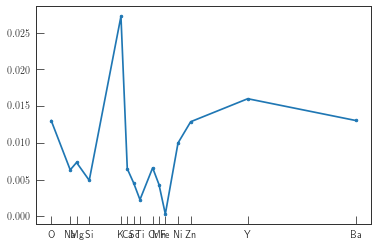

In [42]:
fig, ax = plt.subplots()
ax.plot(Z[zi], opt["psi"][zi])
ax.set_xticks(Z[zi])
ax.set_xticklabels(ordered_element_label_names)

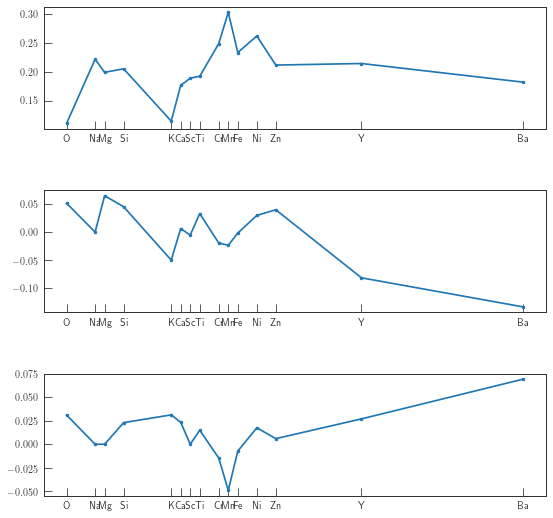

In [47]:
fig, axes = plt.subplots(J, 1, figsize=(9, 9))
ax.set_xticks(Z[zi])
ax.set_xticklabels(ordered_element_label_names)
axes = np.atleast_1d(axes).flatten()

for j, ax in enumerate(axes):
    ax.plot(Z[zi], opt["L"].T[j][zi])
    ax.set_xticks(Z[zi])
    ax.set_xticklabels(ordered_element_label_names)
    

In [48]:
def calculate_factor_scores(opt, data):
    y = data["y"]
    N, D = y.shape
    J = data["J"]
    
    factor_loads = opt["L"].T
    b = factor_loads/np.sqrt(opt["psi"])
    scaled_y = y/np.sqrt(opt["psi"])

    b_sq = np.sum(b**2, axis=1)
    factor_scores = np.dot(scaled_y, b.T) * (1 - J/(N - 1) * b_sq)/(1 + b_sq)
    return factor_scores


In [51]:
J

3

In [112]:
factor_scores = calculate_factor_scores(opt, data)

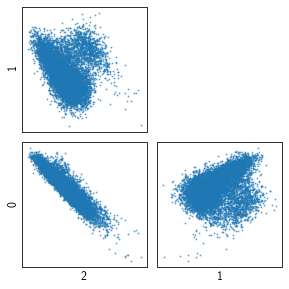

In [109]:
fig = corner_scatter(factor_scores, label_names=np.arange(data["J"]))

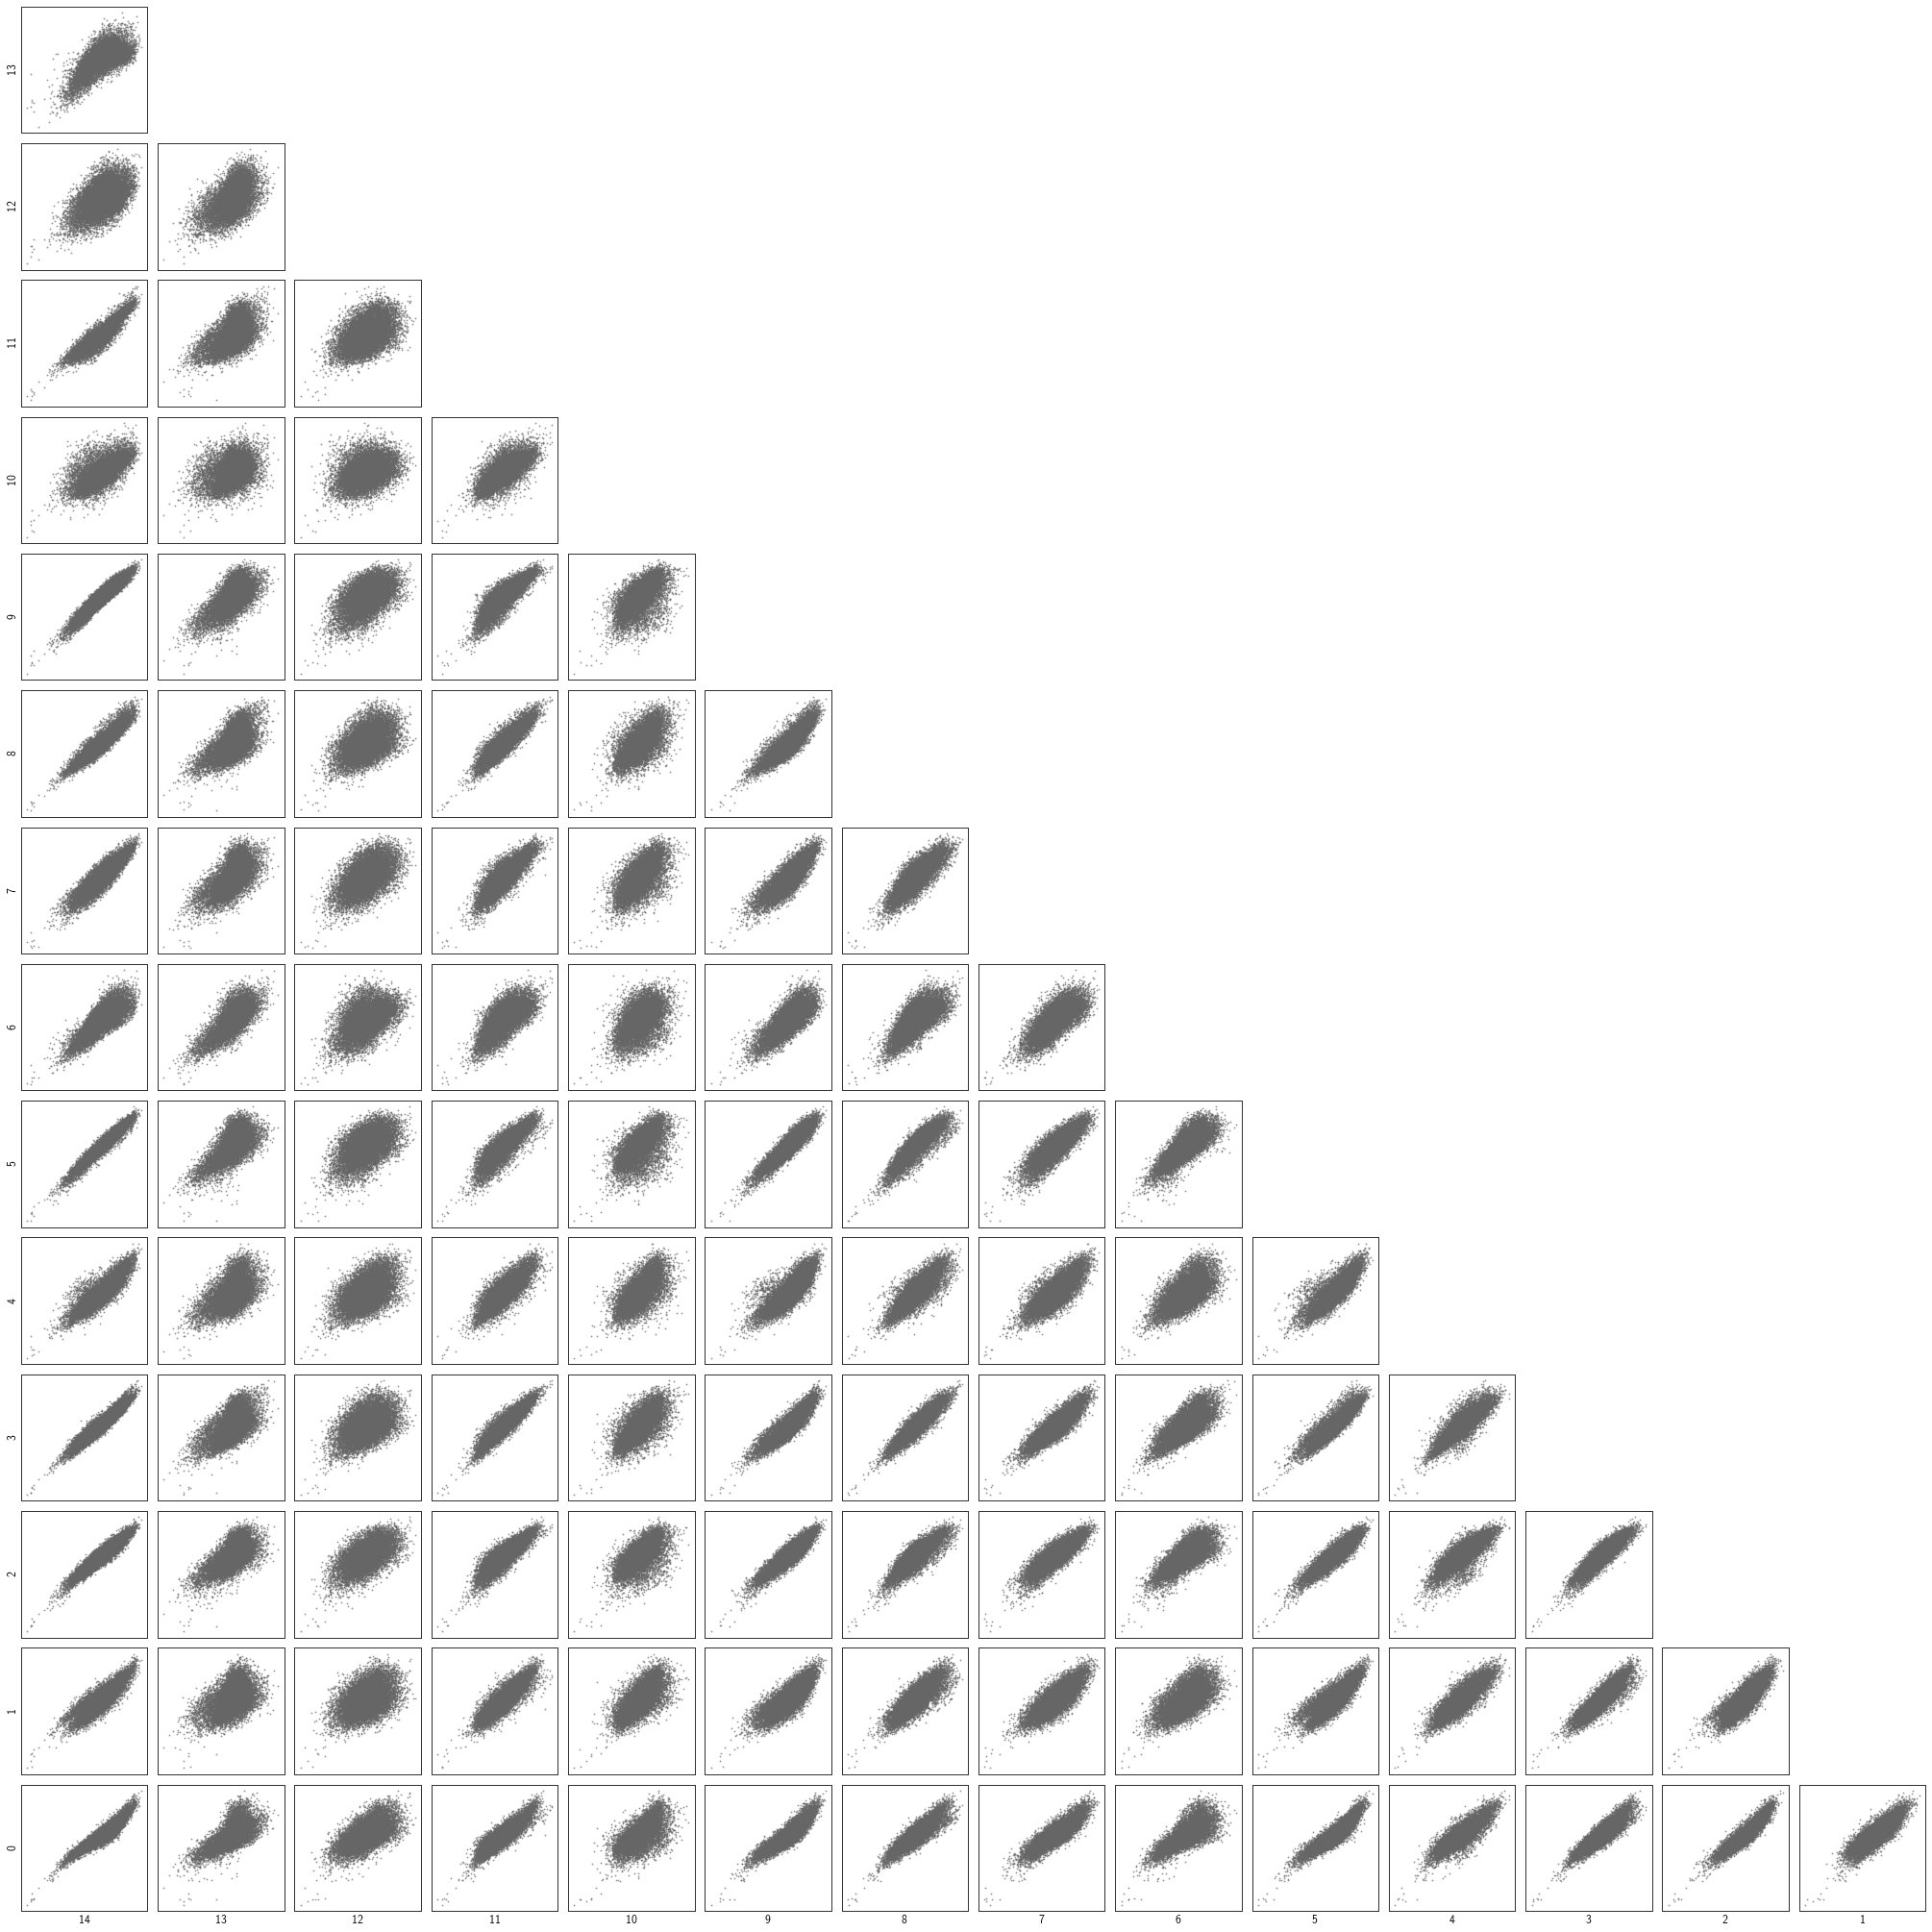

In [117]:
fig = corner_scatter(data["y"], label_names=np.arange(data["D"]), c="#666666", s=1)

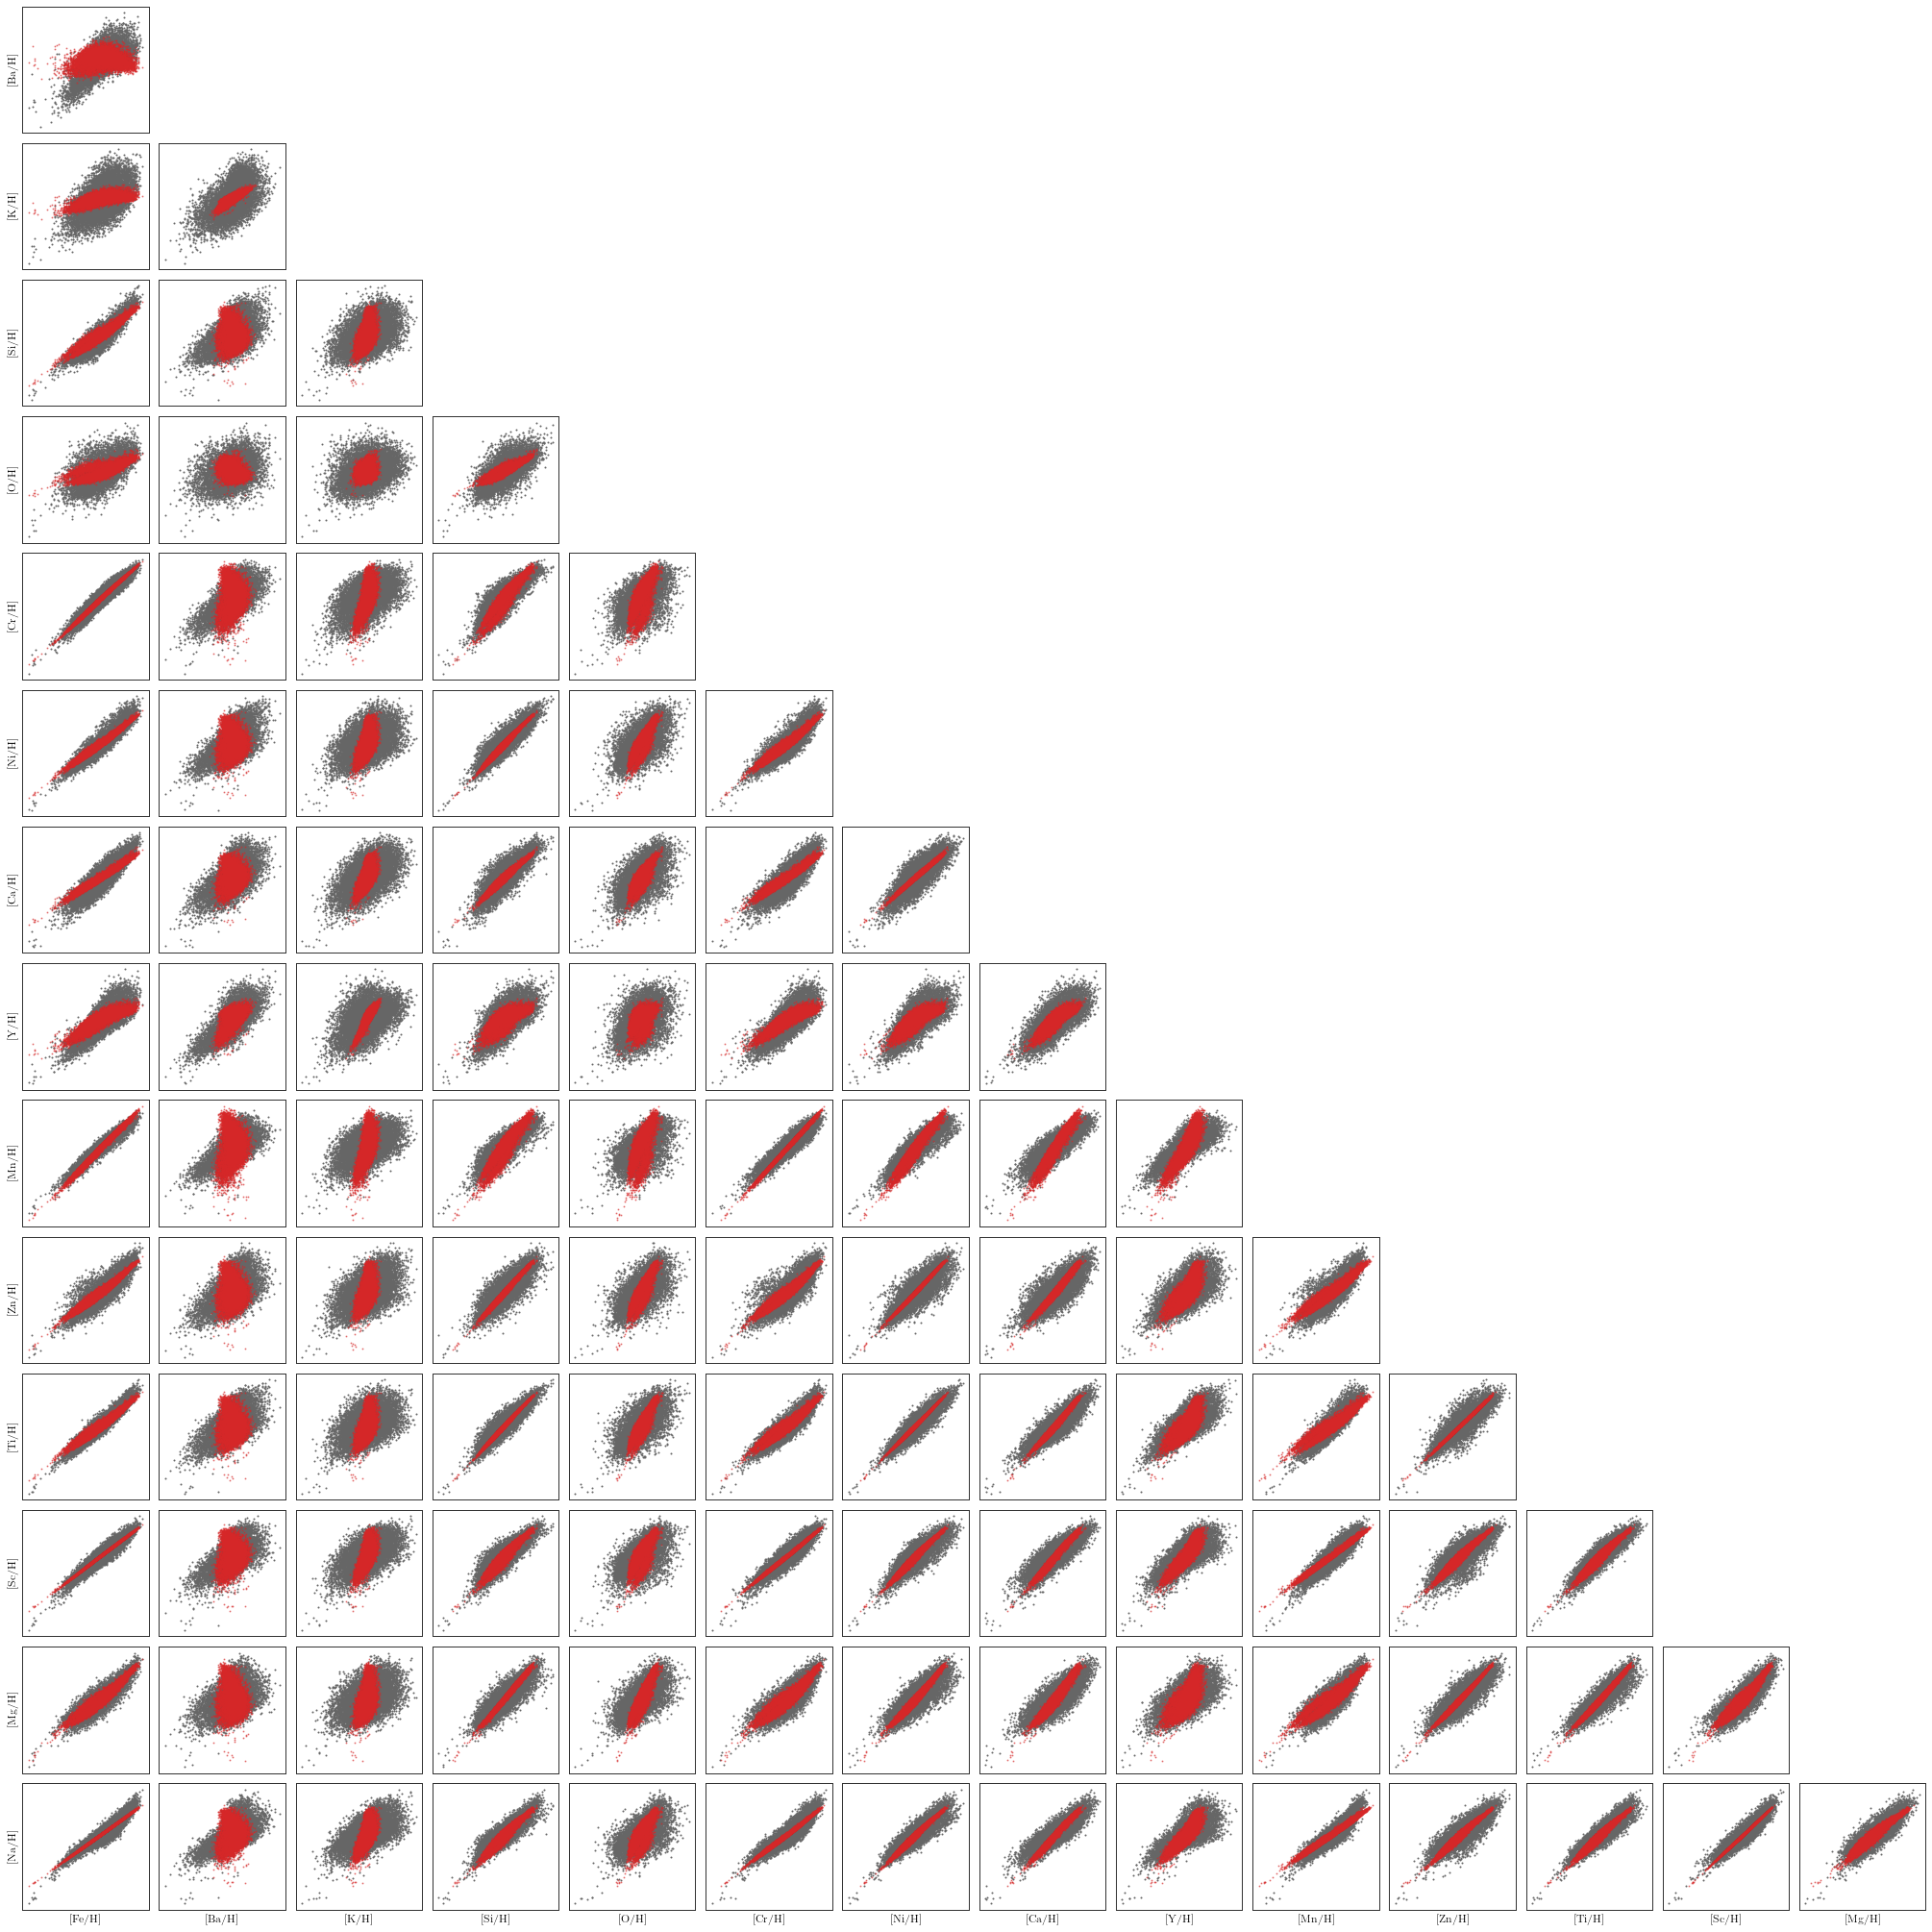

In [127]:
factor_loads = opt["L"].T
y_model = np.dot(factor_scores, factor_loads)



def corner_scatter_overlay(data1, data2, label_names=None, show_ticks=False,
                           data1_kwds=None, data2_kwds=None, figsize=None,
                           **kwargs):
    
    
    N, D = data1.shape
    K = D 
    figsize = figsize if figsize is not None else (2 * K, 2 * K)
    
    fig, axes = plt.subplots(K, K, figsize=figsize)
    axes = np.atleast_2d(axes).T
    
    for k, data in enumerate((data1, data2)):
    
        kwds = dict()
            
        if k == 0 and data1_kwds is not None:
            kwds.update(data1_kwds)
            
        elif k == 1 and data2_kwds is not None:
            kwds.update(data2_kwds)
            
            
        for j, y in enumerate(data.T):
            for i, x in enumerate(data.T):

                try:
                    ax = axes[K - i - 1, K - j - 1]

                except:
                    continue

                if j >= i: 
                    ax.set_visible(False)
                    continue

                ax.scatter(x, y, **kwds)

                if not show_ticks:
                    ax.set_xticks([])
                    ax.set_yticks([])

                if ax.is_last_row() and label_names is not None:
                    ax.set_xlabel(label_names[i])

                if ax.is_first_col() and label_names is not None:
                    ax.set_ylabel(label_names[j])
                
    fig.tight_layout()
    
    return fig

latex_label_names = [r"\textrm{{[{0}/H]}}".format(e.split("_")[0].title()) \
                     for e in use_element_label_names]

fig = corner_scatter_overlay(y, y_model, 
                             label_names=latex_label_names,
                             data1_kwds=dict(c="#666666", s=1, alpha=1),
                             data2_kwds=dict(c="tab:red", s=1, alpha=0.5, zorder=10),
                             figsize=(30, 30))


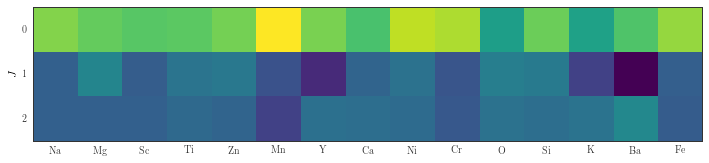

In [146]:
fig, ax = plt.subplots(figsize=(12, 4))
im = ax.imshow(factor_loads, interpolation="nearest")
ax.yaxis.set_tick_params(width=0)
ax.xaxis.set_tick_params(width=0)
ax.set_yticks(np.arange(J))
ax.set_ylabel(r"$J$")

ax.set_xticks(np.arange(D))
_ = ax.set_xticklabels([r"\textrm{{{0}}}".format(e.split("_")[0].title()) \
                    for e in use_element_label_names])


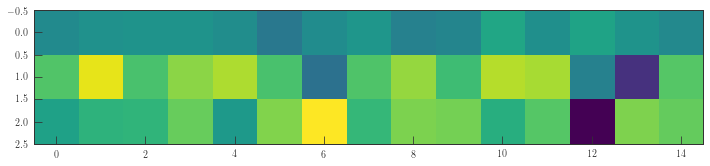

In [152]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(data["y"])
fig, ax = plt.subplots(figsize=(12, 4))
im = ax.imshow(pca.components_, interpolation="nearest")

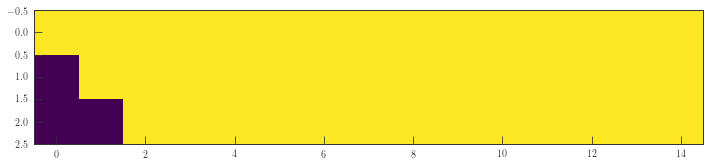

In [157]:
# Let's try initialising from PCA.

L = np.copy(pca.components_)
L[np.tril_indices(data["J"], k=-1)] = 0
fig, ax = plt.subplots(figsize=(12, 4))
im = ax.imshow(np.abs(L), interpolation="nearest", vmin=0, vmax=1e-16)


In [161]:
L.T

array([[-0.27359877,  0.        ,  0.        ],
       [-0.24345272,  0.30601389,  0.        ],
       [-0.2312948 ,  0.00712174, -0.06360389],
       [-0.23399394,  0.14494675,  0.07373097],
       [-0.2625016 ,  0.20430637, -0.20258007],
       [-0.36820921,  0.00926273,  0.126586  ],
       [-0.26729727, -0.40247024,  0.35291238],
       [-0.21739183,  0.02341953, -0.04961205],
       [-0.32127025,  0.16038593,  0.11465643],
       [-0.30387087, -0.02159807,  0.10207589],
       [-0.13894668,  0.22072317, -0.09439444],
       [-0.25073379,  0.1961818 ,  0.03809587],
       [-0.15121549, -0.32307568, -0.84995883],
       [-0.23203243, -0.67915019,  0.11885542],
       [-0.28284452,  0.03608419,  0.06707683]])

In [159]:
L.T[np.diag_indices(3)]

array([-0.27359877,  0.30601389, -0.06360389])

In [176]:
L.T[np.triu_indices(data["J"], 0)]
mask = np.ones(L.T.shape, dtype=bool)
mask[np.triu_indices(data["J"], 0)] = False
L[mask.T]

array([-0.24345272, -0.2312948 , -0.23399394, -0.2625016 , -0.36820921,
       -0.26729727, -0.21739183, -0.32127025, -0.30387087, -0.13894668,
       -0.25073379, -0.15121549, -0.23203243, -0.28284452,  0.00712174,
        0.14494675,  0.20430637,  0.00926273, -0.40247024,  0.02341953,
        0.16038593, -0.02159807,  0.22072317,  0.1961818 , -0.32307568,
       -0.67915019,  0.03608419,  0.07373097, -0.20258007,  0.126586  ,
        0.35291238, -0.04961205,  0.11465643,  0.10207589, -0.09439444,
        0.03809587, -0.84995883,  0.11885542,  0.06707683])

In [173]:
opt["L"].T[mask.T]

array([ 0.19895123,  0.18886245,  0.19229544,  0.21144648,  0.30241238,
        0.21415855,  0.17648771,  0.26146895,  0.24839279,  0.11102527,
        0.20504812,  0.11500942,  0.18206744,  0.23305059, -0.00541959,
        0.03317075,  0.04000021, -0.02366637, -0.08211089,  0.00621879,
        0.02992557, -0.01961774,  0.05174404,  0.04542564, -0.0502926 ,
       -0.13426664, -0.00178476,  0.01499471,  0.00599426, -0.04912686,
        0.02704512,  0.02338998,  0.01755431, -0.01473438,  0.03111528,
        0.02306728,  0.03130282,  0.06938609, -0.00729653])

In [171]:
opt["beta_lower_triangular"]

array([ 0.19895123,  0.18886245,  0.19229544,  0.21144648,  0.30241238,
        0.21415855,  0.17648771,  0.26146895,  0.24839279,  0.11102527,
        0.20504812,  0.11500942,  0.18206744,  0.23305059, -0.00541959,
        0.03317075,  0.04000021, -0.02366637, -0.08211089,  0.00621879,
        0.02992557, -0.01961774,  0.05174404,  0.04542564, -0.0502926 ,
       -0.13426664, -0.00178476,  0.01499471,  0.00599426, -0.04912686,
        0.02704512,  0.02338998,  0.01755431, -0.01473438,  0.03111528,
        0.02306728,  0.03130282,  0.06938609, -0.00729653])

In [179]:
print(opt["L"].T.shape, L.shape)

(3, 15) (3, 15)


In [181]:
opt["sigma_L"]

array(0.12997297)

In [187]:
# TODO: Re-arrange label order so that beta_diag is positive?
init = dict(psi=opt["psi"],
            beta_diag=np.abs(L.T[np.diag_indices(data["J"])]),
            beta_lower_triangular=L[mask.T],
            sigma_L=opt["sigma_L"])

In [188]:
op_kwds = default_op_kwds.copy()
op_kwds.update(
    iter=10000,
    data=data,
    init=init,
    tol_obj=1e-16,
    tol_grad=1e-16,
    tol_param=1e-16,
    tol_rel_grad=1e-16,
    init_alpha=1.0,
)

# 263098

model = stan.load_stan_model("../mlf.stan")
opt = model.optimizing(**op_kwds)

INFO:root:Using pre-compiled model from ../mlf.stan.cached
/home/acas0005/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


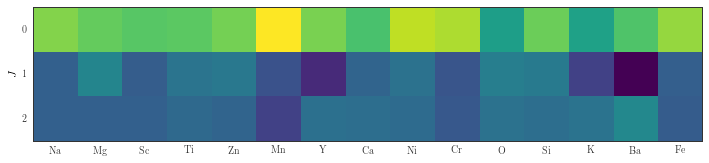

In [189]:
factor_loads = opt["L"].T
fig, ax = plt.subplots(figsize=(12, 4))
im = ax.imshow(factor_loads, interpolation="nearest")
ax.yaxis.set_tick_params(width=0)
ax.xaxis.set_tick_params(width=0)
ax.set_yticks(np.arange(J))
ax.set_ylabel(r"$J$")

ax.set_xticks(np.arange(D))
_ = ax.set_xticklabels([r"\textrm{{{0}}}".format(e.split("_")[0].title()) \
                    for e in use_element_label_names])


Use PCA to re-arrange our latent factors so that they are *most* compatible with our numerical kludge

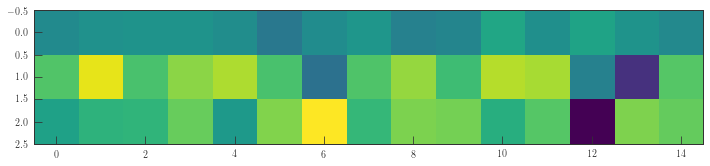

In [192]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(data["y"])
fig, ax = plt.subplots(figsize=(12, 4))
im = ax.imshow(pca.components_, interpolation="nearest")

In [221]:
np.abs(pca.components_.T)

array([[0.27359877, 0.02482911, 0.16228143],
       [0.24345272, 0.30601395, 0.07161257],
       [0.2312948 , 0.00712126, 0.06360586],
       [0.23399394, 0.1449463 , 0.07373264],
       [0.2625016 , 0.20430641, 0.20258016],
       [0.36820921, 0.00926268, 0.12658572],
       [0.26729727, 0.4024702 , 0.35291232],
       [0.21739183, 0.02341963, 0.04961248],
       [0.32127025, 0.16038592, 0.11465574],
       [0.30387087, 0.02159774, 0.10207665],
       [0.13894668, 0.22072316, 0.09439452],
       [0.25073379, 0.19618202, 0.03809586],
       [0.15121549, 0.3230757 , 0.84995875],
       [0.23203243, 0.67915021, 0.11885544],
       [0.28284452, 0.03608408, 0.06707689]])

In [222]:
np.abs(pca.components_.T.flatten())

array([0.27359877, 0.02482911, 0.16228143, 0.24345272, 0.30601395,
       0.07161257, 0.2312948 , 0.00712126, 0.06360586, 0.23399394,
       0.1449463 , 0.07373264, 0.2625016 , 0.20430641, 0.20258016,
       0.36820921, 0.00926268, 0.12658572, 0.26729727, 0.4024702 ,
       0.35291232, 0.21739183, 0.02341963, 0.04961248, 0.32127025,
       0.16038592, 0.11465574, 0.30387087, 0.02159774, 0.10207665,
       0.13894668, 0.22072316, 0.09439452, 0.25073379, 0.19618202,
       0.03809586, 0.15121549, 0.3230757 , 0.84995875, 0.23203243,
       0.67915021, 0.11885544, 0.28284452, 0.03608408, 0.06707689])

In [229]:
np.abs(pca.components_.T.flatten()).reshape(-1, 3)

array([[0.27359877, 0.02482911, 0.16228143],
       [0.24345272, 0.30601395, 0.07161257],
       [0.2312948 , 0.00712126, 0.06360586],
       [0.23399394, 0.1449463 , 0.07373264],
       [0.2625016 , 0.20430641, 0.20258016],
       [0.36820921, 0.00926268, 0.12658572],
       [0.26729727, 0.4024702 , 0.35291232],
       [0.21739183, 0.02341963, 0.04961248],
       [0.32127025, 0.16038592, 0.11465574],
       [0.30387087, 0.02159774, 0.10207665],
       [0.13894668, 0.22072316, 0.09439452],
       [0.25073379, 0.19618202, 0.03809586],
       [0.15121549, 0.3230757 , 0.84995875],
       [0.23203243, 0.67915021, 0.11885544],
       [0.28284452, 0.03608408, 0.06707689]])

In [239]:
np.argsort(np.abs(pca.components_.T.flatten())).reshape(-1, 3)

array([[ 7, 16, 28],
       [22,  1, 43],
       [35, 23,  8],
       [44,  5, 11],
       [32, 29, 26],
       [41, 17, 30],
       [10, 36, 25],
       [ 2, 34, 14],
       [13, 21, 31],
       [ 6, 39,  9],
       [ 3, 33, 12],
       [18,  0, 42],
       [27,  4, 24],
       [37, 20, 15],
       [19, 40, 38]])

array([[0.27359877, 0.02482911, 0.16228143],
       [0.24345272, 0.30601395, 0.07161257],
       [0.2312948 , 0.00712126, 0.06360586],
       [0.23399394, 0.1449463 , 0.07373264],
       [0.2625016 , 0.20430641, 0.20258016],
       [0.36820921, 0.00926268, 0.12658572],
       [0.26729727, 0.4024702 , 0.35291232],
       [0.21739183, 0.02341963, 0.04961248],
       [0.32127025, 0.16038592, 0.11465574],
       [0.30387087, 0.02159774, 0.10207665],
       [0.13894668, 0.22072316, 0.09439452],
       [0.25073379, 0.19618202, 0.03809586],
       [0.15121549, 0.3230757 , 0.84995875],
       [0.23203243, 0.67915021, 0.11885544],
       [0.28284452, 0.03608408, 0.06707689]])